This notebook contains code of the toy code of stable diffusion.
This notebook is made for students of Vision Language Intelligence Lab, Sejong Univeristy.

The scheme of this notebook:


1.   Preliminaries

  *   Install dependencies
  *   Import libraries
  *   Set the GPU

2.   Dataset preparation
  *   Download the dataset
  *   Image feature extraction
  *   Text feature extraction
  *   Load preprocessed features

3.   Modelling

  *   Preliminaries function for UNet
  *   Attention architecture
  *   UNet architecture

4.   Training

  *   Loss function
  *   Training loop

5.   Inference

  *   Sampler module (reverse diffusion module)
  *   Sampling loop
  *   Stable diffusion original



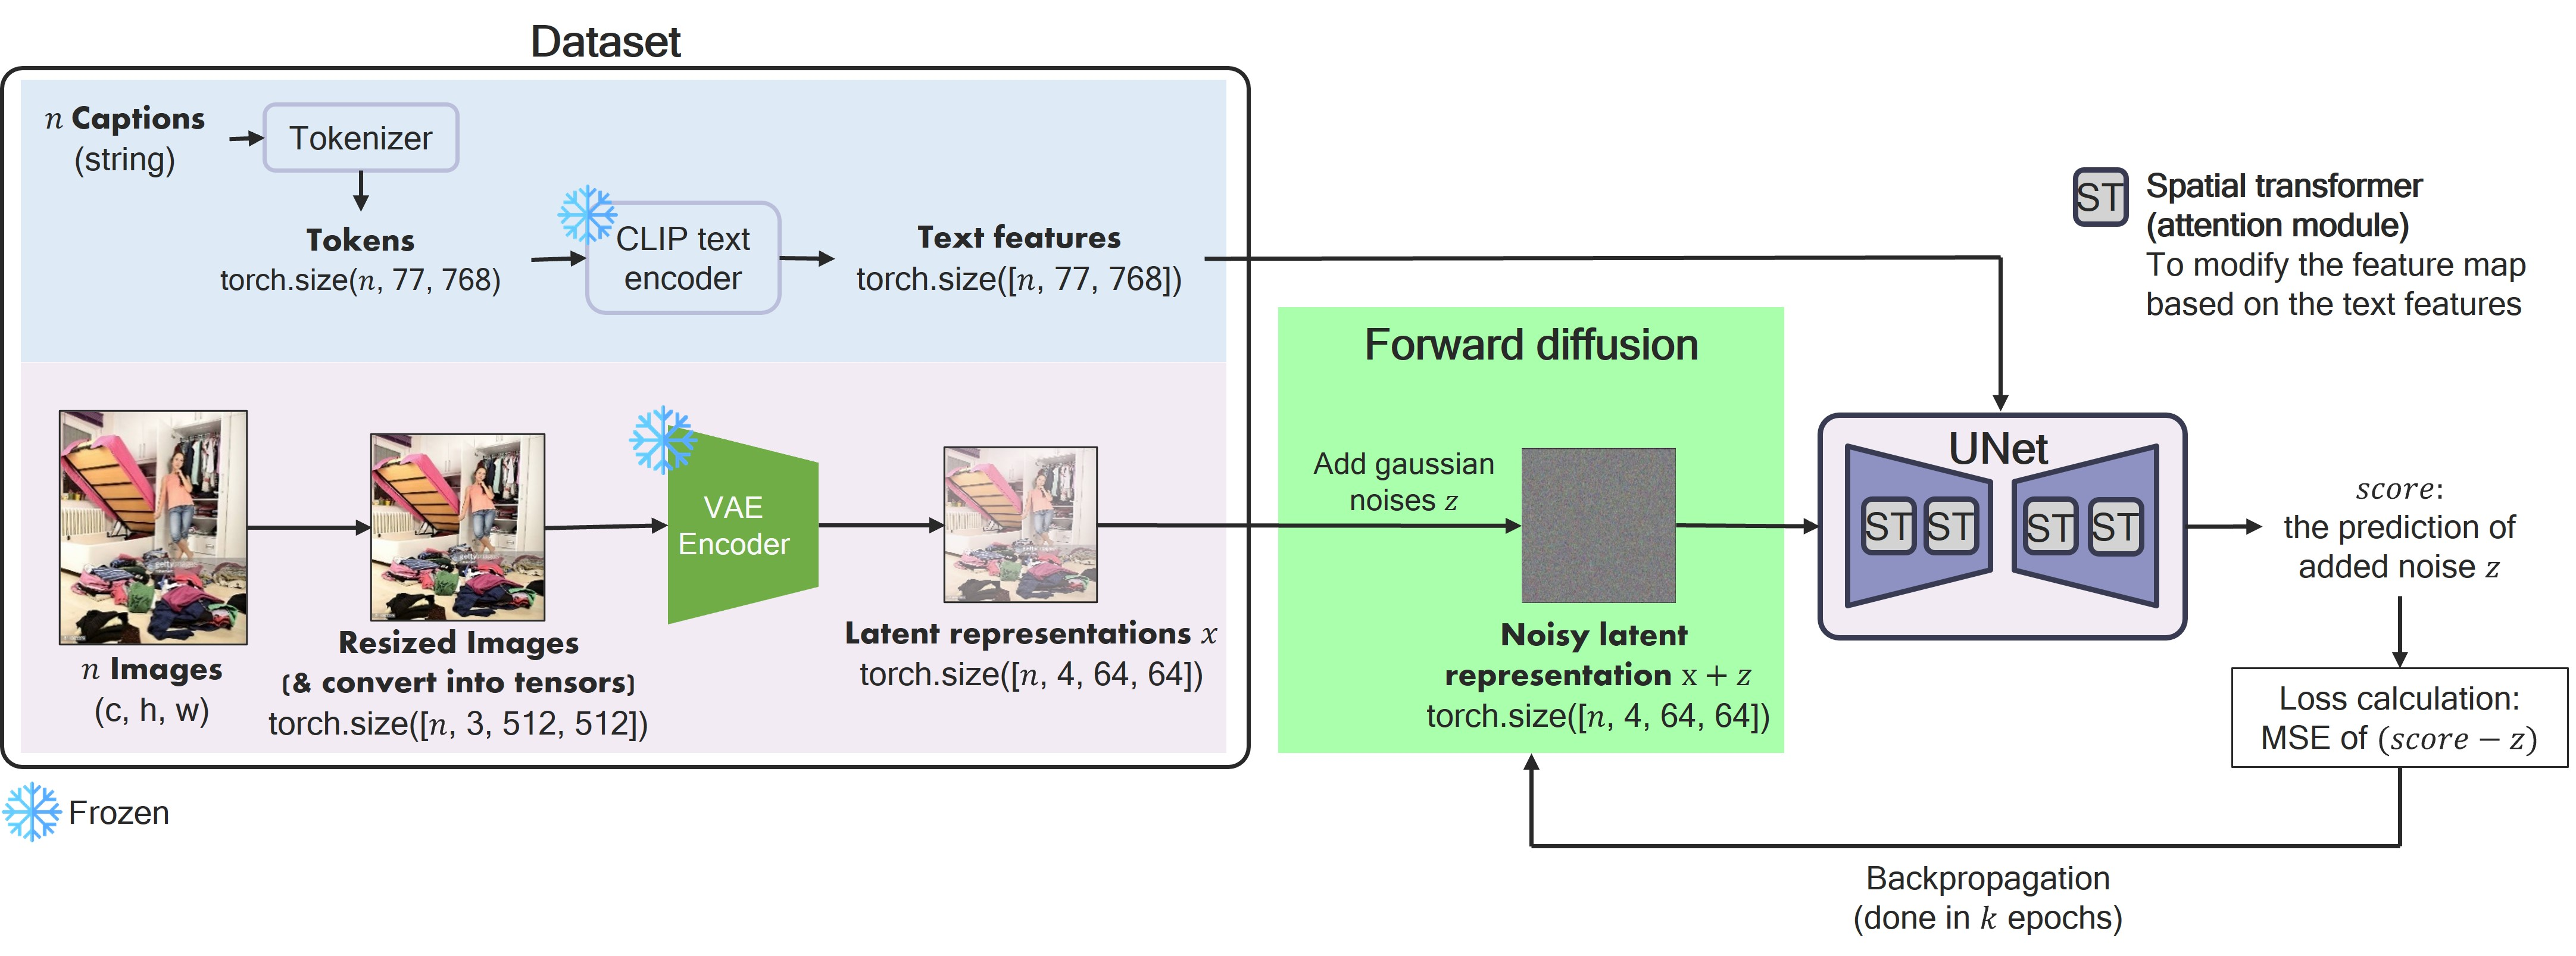

### 0. Preliminaries

In [3]:
# # Install dependencies
# !pip install einops
# !pip install lpips
# !pip install git+https://github.com/openai/CLIP.git
# !pip install transformers
# !pip install diffusers==0.11.1
# !pip install accelerate
# !pip install tensorboard
# !pip install --upgrade ipywidgets
# !pip install --upgrade jupyter ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !pip install matplotlib
# !pip install accelerate
# !pip install yacs
# !pip install easydict
# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install gdown
# !pip install scipy ftfy

In [4]:
# Import library
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from einops import rearrange
import math
from lpips import LPIPS
import csv
from torchvision.transforms import ToTensor, Resize, Compose
from PIL import Image
import requests
from io import BytesIO
import clip
from torchvision.transforms import Compose
from collections import OrderedDict, deque
from easydict import EasyDict as edict
from transformers import CLIPTextModel, CLIPTokenizer
import gdown
from diffusers import AutoencoderKL
import zipfile

In [5]:
# run on GPU for acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available!")

GPU is available!


### 1. Dataset Preparation

In [6]:
# # Download the dataset

# url = 'https://drive.google.com/uc?id=1IHI3-fQr0IHShnzfy6thLo7BAomre4Ek'
# output = 'dataset_pen_bottle.csv'
# gdown.download(url, output, quiet=False)

# url = 'https://drive.google.com/uc?id=15AzKvrdl5V15gClK8dVAWG6qquwI5a7G'
# output = 'pen_bottle.zip'
# gdown.download(url, output, quiet=False)

# # Then you would need to unzip the file:
# with zipfile.ZipFile(output, 'r') as zip_ref:
#     zip_ref.extractall('pen_bottle')

##### 1.1 Image feature extraction

In [7]:
# Load the VAE model which will be used to transform the images into latent representations
ae_model = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
ae_model = ae_model.to(device)
ae_model.eval()

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3,

In [8]:
# csv_file = 'dataset_pen_bottle.csv'
csv_file = 'dataset_conceptual_captions.csv'

# Define transformations for the images
image_transform = Compose([
    Resize((512, 512)), 
    ToTensor()
])

# Read the image file paths and captions from the CSV file
image_file_paths = []
captions = []
with open(csv_file, newline='') as file:
    reader = csv.DictReader(file)
    for row in reader:
        image_file_paths.append(row['image'])
        captions.append(row['caption'])

# Prepare the training images
min_size = float('inf')
latent_representations = []
for image_file_path in image_file_paths:
    try:
        # Open and process the image
        image = Image.open(image_file_path)
        # image = image.convert("RGB")
        image = image_transform(image).unsqueeze(0).to(device)

        # Assuming ae_model is defined and available
        with torch.no_grad():
            latent_representation = ae_model.encode(image).latent_dist.sample()
            latent_representations.append(latent_representation)
        min_size = min(min_size, image.size(2))
    except Exception as e:
        # Print the exception message
        print(f"Exception for file {image_file_path}: {str(e)}")

# Check if there are any latent representations to stack
if latent_representations:
    latent_representations = torch.stack(latent_representations).squeeze(1)
    print(f'done load {len(latent_representations)} images')
else:
    print("No images were successfully processed")

save_latent = latent_representations.cpu().numpy()
np.save('latent_representations_conceptual_captions', save_latent)

##### 1.2 Text feature extraction

In [9]:
# Encode captions using CLIP text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

text_features = []
for caption in captions:
    text = tokenizer(caption, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_feature=text_encoder(text.input_ids)[0]
        text_features.append(text_feature.float())

text_features = torch.stack(text_features)

save_text_features = text_features.cpu().numpy()
np.save('text_features_conceptual_captions', save_text_features)

##### 1.3 Download and load the preprocessed features

In [10]:
# # Download the preprocessed latent representations (image features)

# url = 'https://drive.google.com/uc?id=1rN8SlVn81q9CCZO69FloLHxefN9Pb0Ze'
# output = 'latent_representations_3870_pen_bottle.npy'
# gdown.download(url, output, quiet=False)

# latent_representations_np = np.load('latent_representations_3870_pen_bottle.npy')
# latent_representations = torch.Tensor(latent_representations_np).to(device)

In [11]:
# # Download the preprocessed text features

# url = 'https://drive.google.com/uc?id=1_pMDCZ_8Lnri_Ck7UcY0On_Hmt5Cyd1N'
# output = 'text_features_3870_pen_bottle.npy'
# gdown.download(url, output, quiet=False)

# text_features_np = np.load('text_features_3870_pen_bottle.npy')
# text_features = torch.Tensor(text_features_np).to(device)

In [12]:
# Create TensorDataset from image and text fetaures
# dataset = TensorDataset(latent_representations, text_features)

### 2. Modelling

##### 2.1 Preliminaries functions for UNet

In [13]:
# Get some modules to let time interact

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization.
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]
    # this broadcast the 2d tensor to 4d, add the same value across space.


In [14]:
#Diffusion constant and noise strength

def marginal_prob_std(t, sigma):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  return torch.tensor(sigma**t, device=device)

sigma =  25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

##### 2.2 Attention Module

In [15]:
# Build Our ResBlock
# backbone, Residual Block (Checked)
class ResBlock(nn.Module):
    def __init__(self, in_channel, time_emb_dim, out_channel=None, ):
        super().__init__()
        if out_channel is None:
            out_channel = in_channel
        self.norm1 = nn.GroupNorm(32, in_channel, eps=1e-05, affine=True)
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.time_emb_proj = nn.Linear(in_features=time_emb_dim, out_features=out_channel, bias=True)
        self.norm2 = nn.GroupNorm(32, out_channel, eps=1e-05, affine=True)
        self.dropout = nn.Dropout(p=0.0, inplace=False)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1)
        self.nonlinearity = nn.SiLU()
        if in_channel == out_channel:
            self.conv_shortcut = nn.Identity()
        else:
            self.conv_shortcut = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=1)

    def forward(self, x, t_emb, cond=None):
        # Input conv
        h = self.norm1(x)
        h = self.nonlinearity(h)
        h = self.conv1(h)
        # Time modulation
        if t_emb is not None:
            t_hidden = self.time_emb_proj(self.nonlinearity(t_emb))
            h = h + t_hidden[:, :, None, None]
        # Output conv
        h = self.norm2(h)
        h = self.nonlinearity(h)
        h = self.dropout(h)
        h = self.conv2(h)
        # Skip connection
        return h + self.conv_shortcut(x)


# UpSampling (Checked)
class UpSample(nn.Module):
    def __init__(self, channel, scale_factor=2, mode='nearest'):
        super(UpSample, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.conv = nn.Conv2d(channel, channel, kernel_size=3, stride=1, padding=1, )

    def forward(self, x):
        x = F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode)
        return self.conv(x)


# DownSampling (Checked)
class DownSample(nn.Module):
    def __init__(self, channel, ):
        super(DownSample, self).__init__()
        self.conv = nn.Conv2d(channel, channel, kernel_size=3, stride=2, padding=1, )

    def forward(self, x):
        return self.conv(x)  # F.interpolate(x, scale_factor=1/self.scale_factor, mode=self.mode)

In [16]:
# Build Our Attention / Transformer
# Self and Cross Attention mechanism (Checked)
class CrossAttention(nn.Module):
    """General implementation of Cross & Self Attention multi-head
    """
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=8, ):
        super(CrossAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.to_q = nn.Linear(hidden_dim, embed_dim, bias=False)
        if context_dim is None:
            # Self Attention
            self.to_k = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.to_v = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.self_attn = True
        else:
            # Cross Attention
            self.to_k = nn.Linear(context_dim, embed_dim, bias=False)
            self.to_v = nn.Linear(context_dim, embed_dim, bias=False)
            self.self_attn = False
        self.to_out = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim, bias=True)
        )  # this could be omitted

    def forward(self, tokens, context=None):
        # print('tokens.shape : ', tokens.shape)
        Q = self.to_q(tokens)
        # K = self.to_k(tokens) if self.self_attn else self.to_k(context)

        if self.self_attn:
            K = self.to_k(tokens)
            # print('tokens')
        else: #self attn is False
            K = self.to_k(context)
            # K = self.to_k(tokens)
            # print('context')
        V = self.to_v(tokens) if self.self_attn else self.to_v(context)
        # print(Q.shape, K.shape, V.shape)
        # transform heads onto batch dimension
        Q = rearrange(Q, 'B T (H D) -> (B H) T D', H=self.num_heads, D=self.head_dim)
        if len(K.shape) == 4:
            K = K.squeeze(1)  # This remove an extra dimension
            # print('K.shape:', K.shape)
        K = rearrange(K, 'B T (H D) -> (B H) T D', H=self.num_heads, D=self.head_dim)
        if len(V.shape) == 4:
            V = V.squeeze(1)  # This remove an extra dimension
            # print('V.shape:', V.shape)
        V = rearrange(V, 'B T (H D) -> (B H) T D', H=self.num_heads, D=self.head_dim)
        # print(Q.shape, K.shape, V.shape)
        scoremats = torch.einsum("BTD,BSD->BTS", Q, K)
        attnmats = F.softmax(scoremats / math.sqrt(self.head_dim), dim=-1)
        # print(scoremats.shape, attnmats.shape, )
        ctx_vecs = torch.einsum("BTS,BSD->BTD", attnmats, V)
        # split the heads transform back to hidden.
        ctx_vecs = rearrange(ctx_vecs, '(B H) T D -> B T (H D)', H=self.num_heads, D=self.head_dim)
        # TODO: note this `to_out` is also a linear layer, could be in principle merged into the to_value layer.
        return self.to_out(ctx_vecs)


In [17]:
# Transformer layers
class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, context_dim, num_heads=8):
        super(TransformerBlock, self).__init__()
        self.attn1 = CrossAttention(hidden_dim, hidden_dim, num_heads=num_heads)  # self attention
        self.attn2 = CrossAttention(hidden_dim, hidden_dim, context_dim, num_heads=num_heads)  # cross attention

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)
        # to be compatible with Diffuser, could simplify.
        self.ff = FeedForward_GEGLU(hidden_dim, )
        # A more common version used in transformers.
        # self.ff = nn.Sequential(
        #     nn.Linear(hidden_dim, 3 * hidden_dim),
        #     nn.GELU(),
        #     nn.Linear(3 * hidden_dim, hidden_dim)
        # )

    def forward(self, x, context=None):
        x = self.attn1(self.norm1(x)) + x
        x = self.attn2(self.norm2(x), context=context) + x
        x = self.ff(self.norm3(x)) + x
        return x


class GEGLU_proj(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GEGLU_proj, self).__init__()
        self.proj = nn.Linear(in_dim, 2 * out_dim)

    def forward(self, x):
        x = self.proj(x)
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)


class FeedForward_GEGLU(nn.Module):
    # https://github.com/huggingface/diffusers/blob/95414bd6bf9bb34a312a7c55f10ba9b379f33890/src/diffusers/models/attention.py#L339
    # A variant of the gated linear unit activation function from https://arxiv.org/abs/2002.05202.
    def __init__(self, hidden_dim, mult=4):
        super(FeedForward_GEGLU, self).__init__()
        self.net = nn.Sequential(
            GEGLU_proj(hidden_dim, mult * hidden_dim),
            nn.Dropout(0.0),
            nn.Linear(mult * hidden_dim, hidden_dim)
        )  # to be compatible with Diffuser, could simplify.

    def forward(self, x, ):
        return self.net(x)


class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim, num_heads=8):
        super(SpatialTransformer, self).__init__()
        self.norm = nn.GroupNorm(32, hidden_dim, eps=1e-6, affine=True)
        self.proj_in = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1, padding=0)
        # self.transformer = TransformerBlock(hidden_dim, context_dim, num_heads=8)
        self.transformer_blocks = nn.Sequential(
            TransformerBlock(hidden_dim, context_dim, num_heads=8)
        )  # to be compatible with Diffuser, could simplify.
        self.proj_out = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1, stride=1, padding=0)

    def forward(self, x, cond=None):
        b, c, h, w = x.shape
        x_in = x
        # context = rearrange(context, "b c T -> b T c")
        x = self.proj_in(self.norm(x))
        x = rearrange(x, "b c h w->b (h w) c")
        x = self.transformer_blocks[0](x, cond)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return self.proj_out(x) + x_in


In [18]:
# Container of ResBlock and Spatial Transformers
# Modified Container. Modify the nn.Sequential to time modulated Sequential
class TimeModulatedSequential(nn.Sequential):
    """ Modify the nn.Sequential to time modulated Sequential """
    def forward(self, x, t_emb, cond=None):
        for module in self:
            if isinstance(module, TimeModulatedSequential):
                x = module(x, t_emb, cond)
            elif isinstance(module, ResBlock):
                # For certain layers, add the time modulation.
                x = module(x, t_emb)
            elif isinstance(module, SpatialTransformer):
                # For certain layers, add the class conditioning.
                x = module(x, cond=cond)
            else:
                x = module(x)

        return x


##### 2.3 UNet architecture

In [19]:
# Putting it Together into UNet!
class UNet_SD(nn.Module):

    def __init__(self, in_channels=4,
                 base_channels=320,
                 time_emb_dim=1280,
                 context_dim=768,
                 multipliers=(1, 2, 4, 4),
                 attn_levels=(0, 1, 2),
                 nResAttn_block=2,
                 cat_unet=True):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.in_channels = in_channels
        self.out_channels = in_channels
        base_channels = base_channels
        time_emb_dim = time_emb_dim
        context_dim = context_dim
        multipliers = multipliers
        nlevel = len(multipliers)
        self.base_channels = base_channels
        # attn_levels = [0, 1, 2]
        level_channels = [base_channels * mult for mult in multipliers]
        # Transform time into embedding
        self.time_embedding = nn.Sequential(OrderedDict({
            "linear_1": nn.Linear(base_channels, time_emb_dim, bias=True),
            "act": nn.SiLU(),
            "linear_2": nn.Linear(time_emb_dim, time_emb_dim, bias=True),
        })
        )  # 2 layer MLP
        self.conv_in = nn.Conv2d(self.in_channels, base_channels, 3, stride=1, padding=1)

        # Tensor Downsample blocks
        nResAttn_block = nResAttn_block
        self.down_blocks = TimeModulatedSequential()  # nn.ModuleList()
        self.down_blocks_channels = [base_channels]
        cur_chan = base_channels
        for i in range(nlevel):
            for j in range(nResAttn_block):
                res_attn_sandwich = TimeModulatedSequential()
                # input_chan of first ResBlock is different from the rest.
                res_attn_sandwich.append(ResBlock(in_channel=cur_chan, time_emb_dim=time_emb_dim, out_channel=level_channels[i]))
                if i in attn_levels:
                    # add attention except for the last level
                    res_attn_sandwich.append(SpatialTransformer(level_channels[i], context_dim=context_dim))
                cur_chan = level_channels[i]
                self.down_blocks.append(res_attn_sandwich)
                self.down_blocks_channels.append(cur_chan)
            # res_attn_sandwich.append(DownSample(level_channels[i]))
            if not i == nlevel - 1:
                self.down_blocks.append(TimeModulatedSequential(DownSample(level_channels[i])))
                self.down_blocks_channels.append(cur_chan)

        self.mid_block = TimeModulatedSequential(
            ResBlock(cur_chan, time_emb_dim),
            SpatialTransformer(cur_chan, context_dim=context_dim),
            ResBlock(cur_chan, time_emb_dim),
        )

        # Tensor Upsample blocks
        self.up_blocks = nn.ModuleList() # TimeModulatedSequential()  #
        for i in reversed(range(nlevel)):
            for j in range(nResAttn_block + 1):
                res_attn_sandwich = TimeModulatedSequential()
                res_attn_sandwich.append(ResBlock(in_channel=cur_chan + self.down_blocks_channels.pop(),
                                                  time_emb_dim=time_emb_dim, out_channel=level_channels[i]))
                if i in attn_levels:
                    res_attn_sandwich.append(SpatialTransformer(level_channels[i], context_dim=context_dim))
                cur_chan = level_channels[i]
                if j == nResAttn_block and i != 0:
                    res_attn_sandwich.append(UpSample(level_channels[i]))
                self.up_blocks.append(res_attn_sandwich)
        # Read out from tensor to latent space
        self.output = nn.Sequential(
            nn.GroupNorm(32, base_channels, ),
            nn.SiLU(),
            nn.Conv2d(base_channels, self.out_channels, 3, padding=1),
        )
        self.to(self.device)

    def time_proj(self, time_steps, max_period: int = 10000):
        if time_steps.ndim == 0:
            time_steps = time_steps.unsqueeze(0)
        half = self.base_channels // 2
        frequencies = torch.exp(- math.log(max_period)
                                * torch.arange(start=0, end=half, dtype=torch.float32) / half
                                ).to(device=time_steps.device)
        angles = time_steps[:, None].float() * frequencies[None, :]
        return torch.cat([torch.cos(angles), torch.sin(angles)], dim=-1)

    def forward(self, x, time_steps, cond=None, encoder_hidden_states=None, output_dict=False):
        if cond is None and encoder_hidden_states is not None:
            cond = encoder_hidden_states
        t_emb = self.time_proj(time_steps)
        t_emb = self.time_embedding(t_emb)
        x = self.conv_in(x)
        down_x_cache = [x]
        for module in self.down_blocks:
            x = module(x, t_emb, cond)
            down_x_cache.append(x)
        x = self.mid_block(x, t_emb, cond)
        for module in self.up_blocks:
            x = module(torch.cat((x, down_x_cache.pop()), dim=1), t_emb, cond)
        x = self.output(x)
        if output_dict:
            return edict(sample=x)
        else:
            return x


### 3. Training

##### 3.1 Loss function

In [20]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.
  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, cond=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

##### 3.2 Training loop

In [21]:
# from torch.utils.tensorboard import SummaryWriter

# latent_score_model = torch.nn.DataParallel(UNet_SD())
# latent_score_model = latent_score_model.to(device)

# n_epochs = 1
# lr=1e-4 # learning rate

# #training parameter
# latent_data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
# latent_score_model.train()
# optimizer = Adam(latent_score_model.parameters(), lr=lr)
# scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.5, 0.995 ** epoch))
# tqdm_epoch = trange(n_epochs)
# best_loss = float('inf')

# # Create a SummaryWriter for TensorBoard logging
# writer = SummaryWriter('runs/4_aug')

# index = 0

# for epoch in tqdm_epoch:
#   avg_loss = 0.
#   num_items = 0
#   for z, y in latent_data_loader:
#     z = z.to(device)
#     y = y.to(device)   
#     loss = loss_fn_cond(latent_score_model, z, y, marginal_prob_std_fn)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     avg_loss += loss.item() * z.shape[0]
#     num_items += z.shape[0]

#   scheduler.step()
#   lr_current = scheduler.get_last_lr()[0]
#     # Logging to TensorBoard
#   avg_loss /= num_items
#   writer.add_scalar('Loss/train', avg_loss, epoch)
#   writer.add_scalar('Learning Rate', lr_current, epoch)

#   print(f'{epoch} Average Loss: {avg_loss:.5f} lr {lr_current:.1e}')
#   tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss))

#   if epoch % 10 == 0:
#     filename = 'ckpt_epoch_{}.pth'.format(epoch)
#     torch.save({
#       'epoch': epoch,
#       'model_state_dict': latent_score_model.state_dict(),
#       'optimizer_state_dict': optimizer.state_dict(),
#       }, filename) # Update the checkpoint after each epoch of training.
    
#   if avg_loss < best_loss:
#     best_loss = avg_loss
#     best_filename = 'ckpt_best.pth'
#     torch.save({
#       'epoch': epoch,
#       'model_state_dict': latent_score_model.state_dict(),
#       'optimizer_state_dict': optimizer.state_dict(),
#       }, best_filename) # Update the checkpoint after each epoch of training.

# filename = 'ckpt_last.pth'
# torch.save({
#       'epoch': epoch,
#       'model_state_dict': latent_score_model.state_dict(),
#       'optimizer_state_dict': optimizer.state_dict(),
#       }, filename) # Update the checkpoint after each epoch of training.

# # Tensorboard:
# # Open terminal, cd to your notebook PATH
# # Run tensorboard in terminal: tensorboard --logdir=runs
# # Open the browser: http://localhost:6006/

### 4. Inferencing

##### 4.1 Sampler module (reverse diffusion module)

In [28]:
def Euler_Maruyama_sampler(score_model,
              marginal_prob_std,
              diffusion_coeff,
              batch_size=1,
              x_shape=(4, 64, 64),
              num_steps=500,
              device='cuda',
              eps=1e-3, y=None, show_step=10):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  arr = []
  a=0
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, cond=y) * step_size
      if a % show_step == 0:
        arr.append(mean_x)
      a+=1
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x, arr

##### 4.2 Sampling loop

In [23]:
# Download the checkpoint weight

# url = 'LINK'
# output = 'ckpt_best.pth'
# gdown.download(url, output, quiet=False)

# Load the model
latent_score_model = torch.nn.DataParallel(UNet_SD())
latent_score_model = latent_score_model.to(device)
checkpoint_ldm = torch.load('ckpt_test/ckpt_best.pth', 
                            map_location=device)
latent_score_model.module.load_state_dict(checkpoint_ldm['model_state_dict'])
latent_score_model.eval()

# Load the CLIP text tokenizer and encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")


torch.Size([1, 77, 768])


C:\Users\user\AppData\Local\Temp\ipykernel_15568\4086243583.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_15568\4086243583.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


sample_z shape: torch.Size([1, 4, 64, 64])


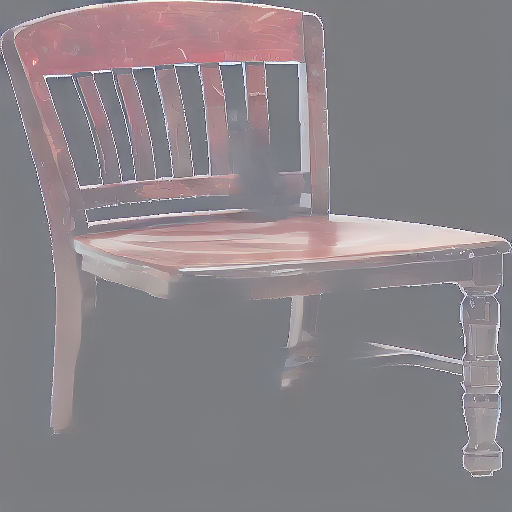

In [31]:
# Inference (or Sampler)
 
sentence = "a pen on a chair"  # input prompt
# captions in training: "a bottle", "a chair", "a pen", "a table", "a bottle on a chair", "a pen on a table"
# you can test: "a bottle on a table", "a pen on a chair"

text = tokenizer(sentence, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_features=text_encoder(text.input_ids)[0]
    print(text_features.shape)

sample_batch_size = 1
num_steps = 50
sampler = Euler_Maruyama_sampler  # ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler']

# Generate samples using the specified sampler.
samples_z, array_z = sampler(latent_score_model,
                    marginal_prob_std_fn,
                    diffusion_coeff_fn,
                    sample_batch_size,
                    num_steps=num_steps,
                    device=device,
                    x_shape=(4, 64, 64),
                    y=text_features,
                    eps=1e-3,
                    show_step=num_steps//num_steps,
                    )

print(f'sample_z shape: {samples_z.shape}')
decoder_samples = ae_model.decode(samples_z).sample

# Convert the image to PIL for displaying or saving it.
image = (decoder_samples / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [30]:
# to refresh the memory
import gc
del samples_z, array_z, decoder_samples, image, images, pil_images
gc.collect()
torch.cuda.empty_cache()

##### 4.3 Stable Diffusion (Original) - Inference

In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Load the text encoder, UNet, scheduler, and VAE

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler

# 1. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 2. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# 3. Load the K-LMS scheduler for scheduling the denoising step (in UNet)
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# 4. Load the autoencoder (VAE) model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

In [ ]:
# move the model to the GPU (for speeding up the process)
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

In [ ]:
# Input the prompt and other parameters
prompt = ["a beautiful mountain with the lake view"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 50            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(1000)   # Seed generator to create the inital latent noise

batch_size = 1

In [ ]:
# Get the text embeddings for the prompt.
# These embeddings will be used to condition the UNet model.
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [ ]:
# Get the unconditional text embeddings for classifier-free guidance.
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
# Generate the initial random noise (latent seed)
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)
print(latents.shape)

In [ ]:
# initialize the scheduler with our chosen num_inference_steps (N)
scheduler.set_timesteps(num_inference_steps)

In [ ]:
latents = latents * scheduler.init_noise_sigma

In [ ]:
# Denoising step (loop for N times)
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

In [ ]:
# scale and decode the image latents with vae.
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

In [ ]:
# Convert the image to PIL for displaying or saving it.
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]